<a   href="https://colab.research.google.com/github/N-Nieto/Relevance_Based_Pruning/blob/master/Relevance_based_pruning_demo.ipynb\" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# This is a toy example for the implementation of Relevance Pruning Method 

### Import GitHub Repository

In [ ]:
!git clone https://github.com/N-Nieto/Relevance_Based_Pruning  --quiet

fatal: destination path 'Relevance_Based_Pruning' already exists and is not an empty directory.


In [ ]:
#@title Imports
# Import libraries
import timeit
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from Relevance_Based_Pruning.Python_Implementation import RBP_Utilitys

In [ ]:
#@title Data Loading

# Data direction and file name
file_name = '/content/Relevance_Based_Pruning/Python_Implementation/Synthetic_data.mat'

# Data Load
X_load = sio.loadmat(file_name = file_name)
X_data = X_load['X']
Y_data = X_load['Y']
   
del (X_load , file_name)

## Data Visualization -  Only the first 2 features contains information

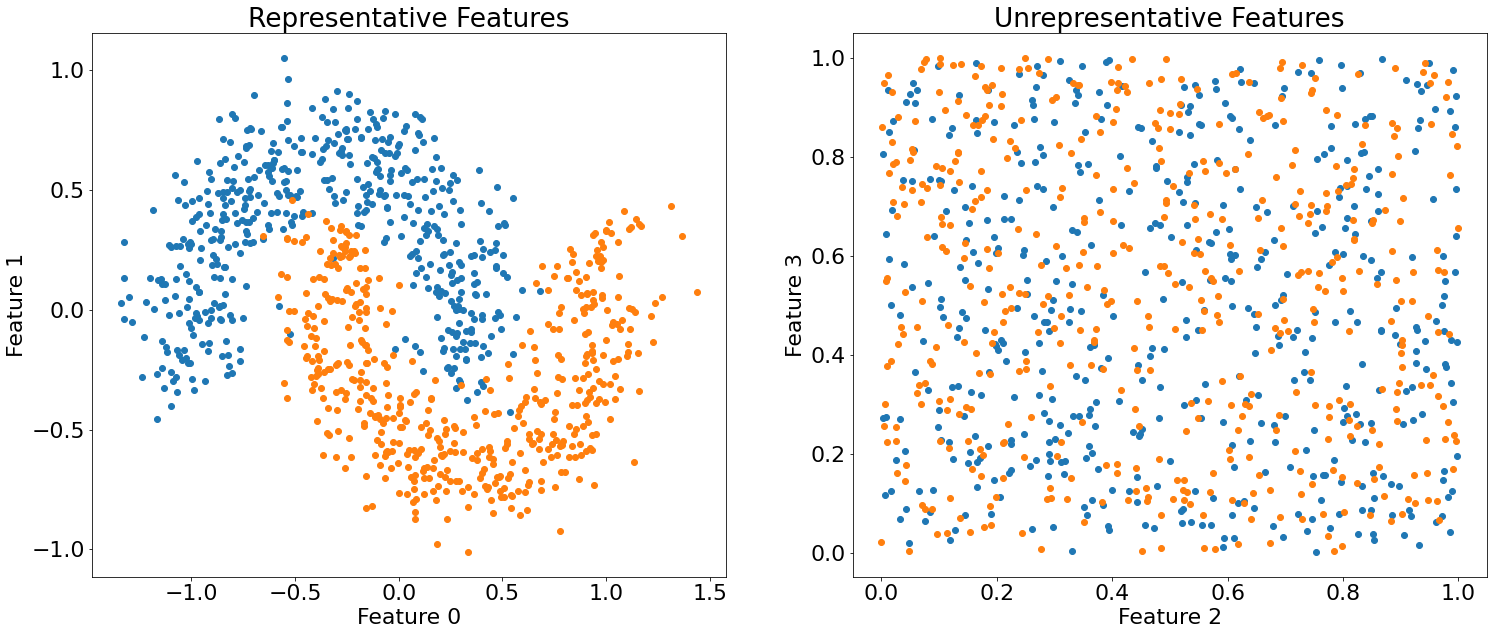

In [ ]:
#@title Data Visualization
# Representative Features
plt.figure(figsize=[25,10])

plt.subplot(1,2,1)
ind_c1 = np.squeeze(Y_data==1)
ind_cm1 =  np.squeeze(Y_data==-1)

plt.scatter(X_data[ind_c1,0], X_data[ind_c1,1])
plt.scatter(X_data[ind_cm1,0], X_data[ind_cm1,1])
plt.title("Representative Features")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# Unrepresentative Features
plt.subplot(1,2,2)

plt.scatter(X_data[ind_c1,3], X_data[ind_c1,4])
plt.scatter(X_data[ind_cm1,3], X_data[ind_cm1,4])
plt.title("Unrepresentative Features")
plt.xlabel("Feature 2")
plt.ylabel("Feature 3")
plt.show()

## Hyperparameter setting

In [ ]:
# Test size. Set as 0.9 for fast computation
test_size = 0.9

# Maximun number of hidden nodes
N_nodes_max = 500

# Number of diferent random initializations
K = 5

# Cross Validations splits
CV = 2

random_state = 23

## Relevance Based Pruning - Main Loop

In [ ]:
# Create a RBP object with all the necessary functions inside
rbp = RBP_Utilitys.RBP()

for cv in range (CV):
    print("CV " + str(cv+1)+" of "+ str(CV))

    # Randomly split in train and test. The same splits are used for RBP and ELM
    x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=test_size, shuffle=True, random_state = random_state+cv)
    
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    for k in range (K):
        print("Initialization " + str(k+1)+ " of "+ str(K))

        # Variable initialization
        acc_prun = 0
        
        start_time = timeit.default_timer()

        # Generate a random network
        W , b = rbp.generate_rand_network(x_train, N_nodes_max)
        
        # Train
        # Note that the fit function is outside the loop where the number of nodes is selected.
        B = rbp.fit(x=x_train,W=W,b=b,y=y_train)
                
        # Pruning: the pruning step could be changed for faster implementations
        for N_nodes_to_keep in range(1,N_nodes_max):
            
              # Prune the network
              W_prun , b_prun, B_prun = rbp.fix_prunning(W, b, B, prn_perc = N_nodes_to_keep, mode = "keep")
              
              # Make a prediction with the pruned netwokr
              y_pred_tst = rbp.predict(x_test, W_prun, b_prun, B_prun)
              
              # Calculaty the accuracy
              acc_aux=accuracy_score(y_test,y_pred_tst)
              
              # Append the accuracy for network size
              acc_prun=np.append(acc_prun,acc_aux)
            
        stop_time = timeit.default_timer()
        #compute 
        time = stop_time - start_time

        # Remove the initialization
        acc_prun=np.delete(acc_prun,0)
        
        if k == 0:    
            #Inicialiced
            Acc_prun = acc_prun
            train_time = time
        else:
            #Stack trials
            Acc_prun = np.vstack((Acc_prun,acc_prun))
            train_time = np.append(train_time,time)
    
    if cv == 0:    
        #Inicialiced
        Acc_RBP_final = Acc_prun
        Time_RBP_final = train_time
    else:
        #Stack trials
        Acc_RBP_final = np.vstack((Acc_RBP_final,Acc_prun))
        Time_RBP_final = np.append(Time_RBP_final,train_time)
    
print("Total training time : " + str(sum(Time_RBP_final)))
print("Mean time for each network training for RBP: "+ str(Time_RBP_final.mean()) + " s")

CV 1 of 2
Initialization 1 of 5
Initialization 2 of 5
Initialization 3 of 5
Initialization 4 of 5
Initialization 5 of 5
CV 2 of 2
Initialization 1 of 5
Initialization 2 of 5
Initialization 3 of 5
Initialization 4 of 5
Initialization 5 of 5
Total time : 96.85224679000044
Mean time for each network training for RBP: 9.685224679000044 s


## Traditional ELM implementation - Main loop

In [ ]:
for cv in range (CV):
    print("CV " + str(cv+1)+" of "+ str(CV))

    # Randomly split in train and test. The same splits are used for RBP and E
    x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=test_size, shuffle=True, random_state = random_state+cv)
    
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    for k in range (K):
        print("Initialization " + str(k+1)+ " of "+ str(K))

        # Variable initialization
        acc_prun = 0
        
        start_time = timeit.default_timer()

        # Generate a big random network
        W_full , b_full = rbp.generate_rand_network(x_train, N_nodes_max)

        # Pruning: the pruning step could be changed for faster implementations
        for N_nodes in range(1, N_nodes_max):

              # Increase the number of weights and bias iteratible
              W =  W_full[:,0:N_nodes] 
              b = b_full[:,0:N_nodes] 
              
              # Train / Note that here the fit fuction has to be inside the nodes loop
              B = rbp.fit(x=x_train,W=W,b=b,y=y_train)
              
              # Make a prediction with the new network
              y_pred_tst = rbp.predict(x_test, W, b, B)
              
              # Calculaty the accuracy
              acc_aux=accuracy_score(y_test,y_pred_tst)
              
              # Append the accuracy for network size
              acc_prun=np.append(acc_prun,acc_aux)
            
        # End of training 
        stop_time = timeit.default_timer()

        #compute time
        time = stop_time - start_time

        # Remove the initialization
        acc_prun=np.delete(acc_prun,0)
        
        if k == 0:    
            #Inicialiced
            Acc_prun = acc_prun
            train_time = time
        else:
            #Stack trials
            Acc_prun = np.vstack((Acc_prun,acc_prun))
            train_time = np.append(train_time,time)
    
    if cv == 0:    
        #Inicialiced
        Acc_ELM_final = Acc_prun
        Time_ELM_final = train_time
    else:
        #Stack trials
        Acc_ELM_final = np.vstack((Acc_ELM_final,Acc_prun))
        Time_ELM_final = np.append(Time_ELM_final,train_time)

print("Total training time : " + str(sum(Time_ELM_final)))
print("Mean time for each network training for RBP: "+ str(Time_ELM_final.mean()) + " s")

CV 1 of 2
Initialization 1 of 5
Initialization 2 of 5
Initialization 3 of 5
Initialization 4 of 5
Initialization 5 of 5
CV 2 of 2
Initialization 1 of 5
Initialization 2 of 5
Initialization 3 of 5
Initialization 4 of 5
Initialization 5 of 5
Total time : 201.6038828139997
Mean time for each network training for RBP: 20.160388281399968 s


## Results comparison 

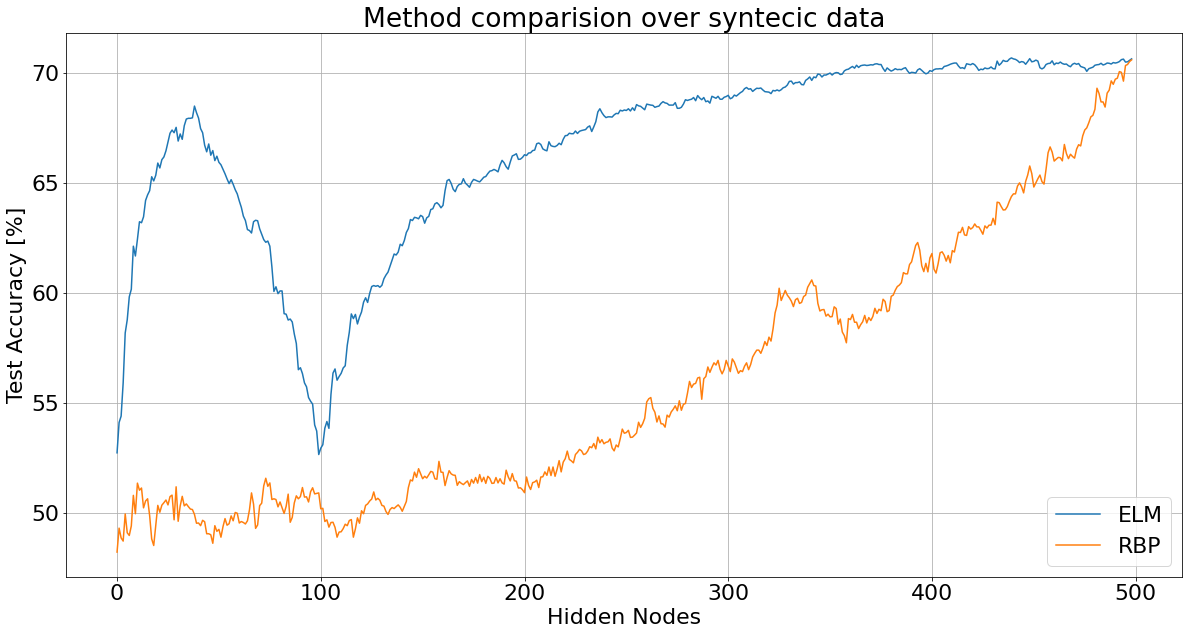

In [ ]:
#@title Plotting
print("Total training time for RBP : " + str(sum(Time_RBP_final)))
print("Total training time for ELM : " + str(sum(Time_ELM_final)))
plt.figure(figsize = [20,10])
plt.plot(np.mean(Acc_ELM_final*100,0), label = "ELM")
plt.plot(np.mean(Acc_RBP_final*100,0), label = "RBP")
plt.xlabel("Hidden Nodes")
plt.ylabel("Test Accuracy [%]")
plt.title("Method comparision over syntecic data")
plt.grid()
plt.legend()
plt.show()

